In [1]:
# Cell 1: Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [13]:
# Cell 2: Load, inspect, and clean the dataset
data = pd.read_csv('winequality-white.csv', sep=';')

# Remove outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data_cleaned = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Check the class distribution after removing outliers
class_distribution_cleaned = data_cleaned['quality'].value_counts()
print("Class Distribution After Removing Outliers:")
print(class_distribution_cleaned)


Class Distribution After Removing Outliers:
quality
6    1866
5    1106
7     797
4      89
Name: count, dtype: int64


In [14]:
# Cell 3: Prepare data
X = data.drop(columns=['quality'])
y = data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Cell 4: Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Cell 5: Define classifiers
rf_classifier = RandomForestClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()


In [24]:
# Cell 6: Evaluate classifiers
from sklearn.metrics import precision_score, recall_score

# Define evaluation function
def evaluate_classifier_metrics(classifier, X_train_scaled, y_train):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42)
    accuracy_scores = cross_val_score(classifier, X_train_scaled, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    precision_scores = cross_val_score(classifier, X_train_scaled, y_train, scoring='precision_weighted', cv=cv, n_jobs=-1)
    recall_scores = cross_val_score(classifier, X_train_scaled, y_train, scoring='recall_weighted', cv=cv, n_jobs=-1)
    return accuracy_scores.mean(), accuracy_scores.std(), precision_scores.mean(), precision_scores.std(), recall_scores.mean(), recall_scores.std()

# Evaluate Random Forest Classifier
rf_mean_accuracy, rf_std_accuracy, rf_mean_precision, rf_std_precision, rf_mean_recall, rf_std_recall = evaluate_classifier_metrics(rf_classifier, X_train_scaled, y_train)

# Evaluate K-Nearest Neighbors Classifier
knn_mean_accuracy, knn_std_accuracy, knn_mean_precision, knn_std_precision, knn_mean_recall, knn_std_recall = evaluate_classifier_metrics(knn_classifier, X_train_scaled, y_train)

# Create DataFrame
evaluation_results = pd.DataFrame({
    'Classifier': [rf_classifier.__class__.__name__, knn_classifier.__class__.__name__],
    'Mean Accuracy': [rf_mean_accuracy, knn_mean_accuracy],
    'Std Accuracy': [rf_std_accuracy, knn_std_accuracy],
    'Mean Precision': [rf_mean_precision, knn_mean_precision],
    'Std Precision': [rf_std_precision, knn_std_precision],
    'Mean Recall': [rf_mean_recall, knn_mean_recall],
    'Std Recall': [rf_std_recall, knn_std_recall]
})

evaluation_results['Mean Accuracy']


,Classifier,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall
0,RandomForestClassifier,0.642471,0.010313,0.650265,0.011053,0.642471,0.010313
1,KNeighborsClassifier,0.532848,0.011344,0.517532,0.012561,0.532848,0.011344


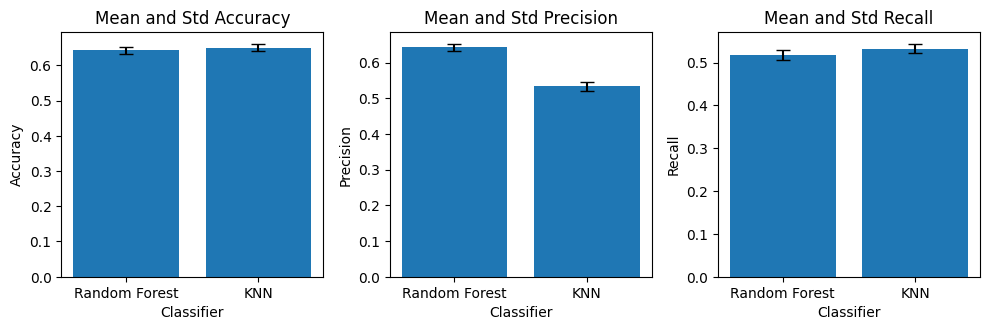

In [41]:
import matplotlib.pyplot as plt

# Define data
metrics = ['Accuracy', 'Precision', 'Recall']
mean_values = [rf_mean_accuracy, rf_mean_precision, rf_mean_recall, knn_mean_accuracy, knn_mean_precision, knn_mean_recall]
std_values = [rf_std_accuracy, rf_std_precision, rf_std_recall, knn_std_accuracy, knn_std_precision, knn_std_recall]

# Plot Mean and Std for each metric
plt.figure(figsize=(10, 6))
for i in range(len(metrics)):
    plt.subplot(2, 3, i+1)
    plt.bar(['Random Forest', 'KNN'], mean_values[i*2:(i+1)*2], yerr=std_values[i*2:(i+1)*2], capsize=5)
    plt.title(f'Mean and Std {metrics[i]}')
    plt.xlabel('Classifier')
    plt.ylabel(metrics[i])
plt.tight_layout()
plt.show()


In [31]:
# Cell 7: Identify the best classifier
best_classifier = rf_classifier if evaluation_results['Mean Accuracy'][0] > evaluation_results['Mean Accuracy'][1] else knn_classifier
print("Best Classifier:", best_classifier.__class__.__name__)


Best Classifier: RandomForestClassifier


In [40]:
evaluation_results.columns

Index(['Classifier', 'Mean Accuracy', 'Std Accuracy', 'Mean Precision',
       'Std Precision', 'Mean Recall', 'Std Recall'],
      dtype='object')

In [44]:
# Cell 8: Build final model using the best classifier
ros = RandomOverSampler(random_state=42)
# Build pipeline for RandomForestClassifier
rf_pipeline = Pipeline([('oversample', ros), ('classifier', rf_classifier)])
rf_pipeline.fit(X_train_scaled, y_train)

# Build pipeline for KNeighborsClassifier
knn_pipeline = Pipeline([('oversample', ros), ('classifier', knn_classifier)])
knn_pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('oversample', RandomOverSampler(random_state=42)),
                ('classifier', KNeighborsClassifier())])

In [54]:
# Cell 9: Report the models' performance on the test set
import numpy as np
# For RandomForestClassifier
y_pred_test_rf = rf_pipeline.predict(X_test_scaled)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
precision_test_rf = precision_score(y_test, y_pred_test_rf, average='weighted')
recall_test_rf = recall_score(y_test, y_pred_test_rf, average='weighted')

# For KNeighborsClassifier
y_pred_test_knn = knn_pipeline.predict(X_test_scaled)
accuracy_test_knn = accuracy_score(y_test, y_pred_test_knn)
precision_test_knn = precision_score(y_test, y_pred_test_knn, average='weighted')
recall_test_knn = recall_score(y_test, y_pred_test_knn, average='weighted')

# Calculate mean and standard deviation for RandomForestClassifier
rf_metrics = {
    'Accuracy': accuracy_test_rf,
    'Precision': precision_test_rf,
    'Recall': recall_test_rf
}
rf_mean = {metric: np.mean(score) for metric, score in rf_metrics.items()}
rf_std = {metric: np.std(score) for metric, score in rf_metrics.items()}

# Calculate mean and standard deviation for KNeighborsClassifier
knn_metrics = {
    'Accuracy': accuracy_test_knn,
    'Precision': precision_test_knn,
    'Recall': recall_test_knn
}
knn_mean = {metric: np.mean(score) for metric, score in knn_metrics.items()}
knn_std = {metric: np.std(score) for metric, score in knn_metrics.items()}

C:\Users\SYSTEM-1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SYSTEM-1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
import numpy as np

# Calculate mean and standard deviation for RandomForestClassifier
rf_metrics = {
    'Accuracy': accuracy_test_rf,
    'Precision': precision_test_rf,
    'Recall': recall_test_rf
}
rf_mean = {metric: np.mean(score) for metric, score in rf_metrics.items()}
rf_std = {metric: np.std(score) for metric, score in rf_metrics.items()}

# Calculate mean and standard deviation for KNeighborsClassifier
knn_metrics = {
    'Accuracy': accuracy_test_knn,
    'Precision': precision_test_knn,
    'Recall': recall_test_knn
}
knn_mean = {metric: np.mean(score) for metric, score in knn_metrics.items()}
knn_std = {metric: np.std(score) for metric, score in knn_metrics.items()}


In [57]:
import pandas as pd

# Create DataFrame for RandomForestClassifier
rf_df = pd.DataFrame({'Classifier': 'RandomForestClassifier',
                      'Metric': ['Accuracy', 'Precision', 'Recall'],
                      'Mean': [rf_mean['Accuracy'], rf_mean['Precision'], rf_mean['Recall']],
                      'Std': [rf_std['Accuracy'], rf_std['Precision'], rf_std['Recall']]})

# Create DataFrame for KNeighborsClassifier
knn_df = pd.DataFrame({'Classifier': 'KNeighborsClassifier',
                       'Metric': ['Accuracy', 'Precision', 'Recall'],
                       'Mean': [knn_mean['Accuracy'], knn_mean['Precision'], knn_mean['Recall']],
                       'Std': [knn_std['Accuracy'], knn_std['Precision'], knn_std['Recall']]})

# Concatenate both DataFrames
result_df = pd.concat([rf_df, knn_df], ignore_index=True)

# Print the DataFrame
print(result_df)


               Classifier     Metric      Mean  Std
0  RandomForestClassifier   Accuracy  0.692857  0.0
1  RandomForestClassifier  Precision  0.694795  0.0
2  RandomForestClassifier     Recall  0.692857  0.0
3    KNeighborsClassifier   Accuracy  0.492857  0.0
4    KNeighborsClassifier  Precision  0.532575  0.0
5    KNeighborsClassifier     Recall  0.492857  0.0


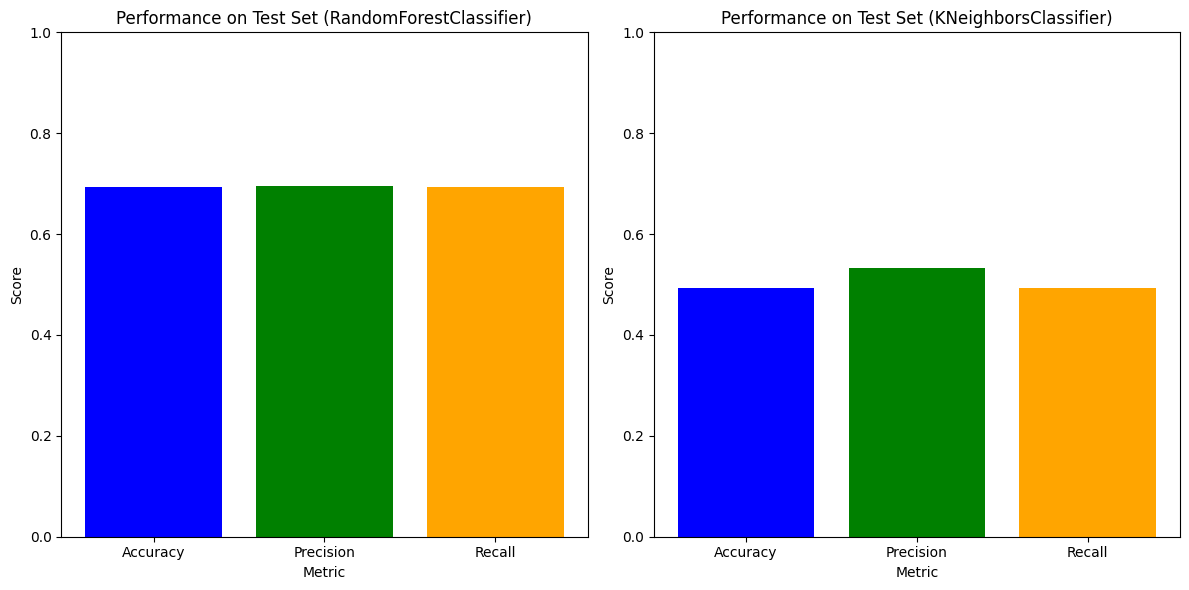

In [46]:
# Define data for RandomForestClassifier
metrics_rf = ['Accuracy', 'Precision', 'Recall']
values_rf = [accuracy_test_rf, precision_test_rf, recall_test_rf]

# Define data for KNeighborsClassifier
metrics_knn = ['Accuracy', 'Precision', 'Recall']
values_knn = [accuracy_test_knn, precision_test_knn, recall_test_knn]

# Plot performance on the test set for RandomForestClassifier
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot 1 for RandomForestClassifier
plt.bar(metrics_rf, values_rf, color=['blue', 'green', 'orange'])
plt.title("Performance on Test Set (RandomForestClassifier)")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization of scores

# Plot performance on the test set for KNeighborsClassifier
plt.subplot(1, 2, 2)  # Subplot 2 for KNeighborsClassifier
plt.bar(metrics_knn, values_knn, color=['blue', 'green', 'orange'])
plt.title("Performance on Test Set (KNeighborsClassifier)")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization of scores

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
